In [ ]:
import pandas as pd
import numpy as np
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import os
import argparse
import sys
from scipy import optimize
from helper_functions import *

bamfile = "/Volumes/HNSD01/outdir/tsma_validation_bam/4-LC030TS_M569-M769.trimGalore_R1_bismark_bt2_pe.sorted.bam"
sampleid = bamfile.split("/")[-1].split(".")[0]

tsma_regiondf = pd.read_excel("./assets/12967_2024_5416_MOESM1_ESM.xlsx")

# regionname = "chr1_182808141_182808238"
outputdir = "./output"
os.system(f"mkdir -p {outputdir}")

for regionname in tsma_regiondf["Region_name"].to_list():
    if os.path.isfile(os.path.join(outputdir, "read_at_region_{}.csv".format(regionname))) == False:
        region = f"chr{regionname.split('_')[0]}:{regionname.split('_')[1]}-{regionname.split('_')[2]}"

        sampleid = bamfile.split("/")[-1].split(".")[0]

        # ***** collect reads from regions from the TSMA
        bamfile_obj = pysam.AlignmentFile(bamfile).fetch(region = region)
        reads = []
        for read in bamfile_obj:
            reads.append(read)
        readdf = pd.DataFrame()
        readdf["chrom"] = [read.to_dict()["ref_name"] for read in reads]
        readdf["start"] = [read.to_dict()["ref_pos"] for read in reads]
        readdf["cigar"] = [read.to_dict()["cigar"] for read in reads]
        readdf["flen"] = [read.to_dict()["length"] for read in reads]
        readdf["seq"] = [read.to_dict()["seq"] for read in reads]
        readdf["methyl_string"] = [read.to_dict()["tags"][2] for read in reads]
        readdf["XR"] = [read.to_dict()["tags"][3] for read in reads]
        readdf["XG"] = [read.to_dict()["tags"][4] for read in reads]
        readdf["sample"] = sampleid
        readdf["region"] = region

        readdf.to_csv(os.path.join(outputdir, "read_at_region_{}.csv".format(regionname)))

<Axes: ylabel='label'>

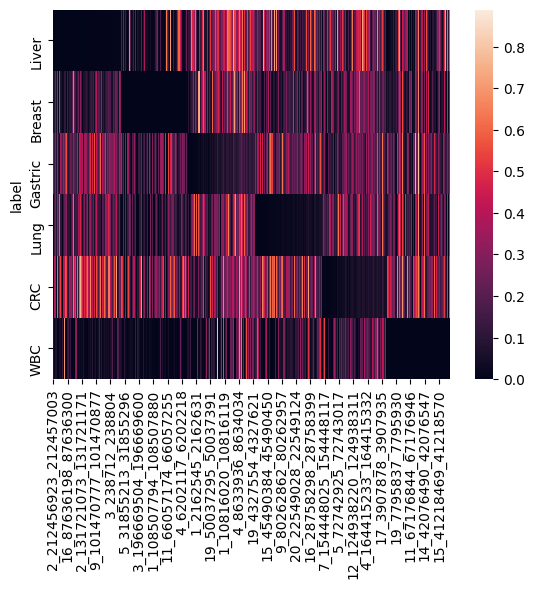

In [ ]:
atlas_labels = ["Liver", "Breast", "Gastric", "Lung", "CRC", "WBC"]
atlasdf = pd.read_csv("./assets/tsma-published/final_atlas.csv")
sns.heatmap(data = atlasdf.set_index("label"))

In [3]:
all_atlas_regions = [item for item in atlasdf.columns if item != "label"]
full_betadf = pd.DataFrame()

for regionname in tqdm(all_atlas_regions):
    path_to_all_fa = "/Volumes/HNSD01/storage/ref/hg19" 
    readdf = pd.read_csv(f"/Users/hieunguyen/src/tsma_validation/output/read_at_region_{regionname}.csv")
    df = readdf.copy()

    region_chrom = f"chr{regionname.split('_')[0]}"
    region_start = int(regionname.split("_")[1])
    region_end = int(regionname.split("_")[2])
    refseq_at_cluster = get_refseq(path_to_all_fa = path_to_all_fa, 
                                        chrom = region_chrom, 
                                        start = region_start, 
                                        end = region_end + 1)
    all_cpg_in_cluster = [m.start(0) for m in re.finditer("CG", refseq_at_cluster)]
    cpg_coords = [item + region_start for item in all_cpg_in_cluster]

    df["check_cigar"] = df["cigar"].apply(lambda x: bool(pattern.fullmatch(x)))
    df = df[df["check_cigar"] == True]

    if df.shape[0] != 0:
        df["end"] = df[["start", "cigar"]].apply(lambda x: int(x[0]) + int(x[1].replace("M", "")), axis = 1)
        for cpg_pos in cpg_coords:
            df[cpg_pos] = df[["start", "end", "seq"]].apply(lambda x: get_CpG_status(x[0], x[1], x[2], cpg_pos, mode = "num"), axis = 1)
        
        betadf = pd.DataFrame(data = [sampleid])
        betadf.columns = ["sample"]
                                    
        for cpg_pos in cpg_coords:    
            tmpdf = df[["sample", cpg_pos]].copy()
            tmpcountdf = tmpdf.groupby('sample')[cpg_pos].apply(lambda x: (x == 1).sum()/((x == 0).sum() + (x == 1).sum()) ).reset_index(name= "meth_level_{}".format(cpg_pos))
            betadf = betadf.merge(tmpcountdf[["sample", "meth_level_{}".format(cpg_pos)]], right_on = "sample", left_on = "sample", how = "outer")
                                    
        betadf["avg_beta"] = betadf[[item for item in betadf.columns if item != "sample"]].apply(lambda x: np.mean([item for item in x if np.isnan(item) == False]), axis = 1)
        betadf = betadf[["sample", "avg_beta"]]
        betadf.columns = ["sample", regionname]

        full_betadf = pd.concat([full_betadf, betadf.set_index("sample").T], axis = 0)

full_betadf.to_csv(os.path.join(outputdir, f"full_betadf_{sampleid}.csv"))

100%|██████████| 2945/2945 [19:17<00:00,  2.54it/s] 


In [40]:
atlasdf

,label,2_212456923_212457003,11_48977114_48977214,14_70655355_70655451,1_236227424_236227521,1_236228410_236228495,1_236228513_236228613,2_155555198_155555300,22_33197693_33197794,17_74865923_74866022,...,12_6184228_6184317,12_7068288_7068372,16_89789205_89789295,2_25354927_25355001,18_74811491_74811532,6_37018081_37018165,12_6881520_6881617,6_37017872_37017953,4_122872531_122872631,4_123748799_123748880
0,Liver,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.418506,0.611821,0.122057,0.157305,0.553670,0.577994,0.306061,0.568302,0.074334,0.057576
1,Breast,0.284444,0.083333,0.054012,0.190571,0.053935,0.114156,0.106928,0.057316,0.165046,...,0.268849,0.562190,0.199702,0.271329,0.495522,0.380671,0.296528,0.389236,0.054423,0.061174
2,Gastric,0.242208,0.238636,0.283982,0.216601,0.385185,0.384469,0.228788,0.256446,0.249242,...,0.135017,0.565025,0.153134,0.172006,0.519474,0.386183,0.490152,0.631890,0.162486,0.259246
3,Lung,0.106970,0.000000,0.212987,0.202352,0.168350,0.209917,0.415043,0.120110,0.247511,...,0.343831,0.600869,0.039332,0.246970,0.433939,0.506133,0.250000,0.642027,0.107125,0.114115
4,CRC,0.205455,0.030303,0.291246,0.398384,0.502289,0.481703,0.383045,0.236159,0.767260,...,0.176776,0.578338,0.013203,0.173268,0.597970,0.596759,0.397727,0.537590,0.248320,0.077694
5,WBC,0.249837,0.083333,0.000000,0.151247,0.000000,0.000000,0.028150,0.050926,0.013889,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [47]:
deconv_atlas.head()

,region,Liver,Breast,Gastric,Lung,CRC,WBC,index,4-LC030TS_M569-M769
0,2_212456923_212457003,0.0,0.284444,0.242208,0.106970,0.205455,0.249837,2_212456923_212457003,1.000000
1,14_70655355_70655451,0.0,0.054012,0.283982,0.212987,0.291246,0.000000,14_70655355_70655451,0.042116
2,1_236227424_236227521,0.0,0.190571,0.216601,0.202352,0.398384,0.151247,1_236227424_236227521,0.044077
3,1_236228410_236228495,0.0,0.053935,0.385185,0.168350,0.502289,0.000000,1_236228410_236228495,0.000094
4,1_236228513_236228613,0.0,0.114156,0.384469,0.209917,0.481703,0.000000,1_236228513_236228613,0.021543


In [48]:
full_betadf.head()

sample,4-LC030TS_M569-M769
2_212456923_212457003,1.000000
14_70655355_70655451,0.042116
1_236227424_236227521,0.044077
1_236228410_236228495,0.000094
1_236228513_236228613,0.021543


In [38]:
deconv_atlas = atlasdf.set_index("label").T.reset_index()
deconv_atlas.columns = ["region"] + list(deconv_atlas.columns[1:])
deconv_atlas = deconv_atlas.merge(full_betadf.reset_index(), right_on = "index", left_on = "region")
deconv_atlas = deconv_atlas[~deconv_atlas[sampleid].isna()]
mixture, residual = optimize.nnls(deconv_atlas[atlas_labels].to_numpy(), deconv_atlas[sampleid].to_numpy())
mixture /= np.sum(mixture)

tmp_resdf = pd.DataFrame(data = atlas_labels, columns = ["TOO"])
tmp_resdf[sampleid] = mixture
tmp_resdf

,TOO,4-LC030TS_M569-M769
0,Liver,0.113117
1,Breast,0.000000
2,Gastric,0.065958
3,Lung,0.021718
4,CRC,0.000000
5,WBC,0.799208
